# Кластеризация предобработанных данных

Данные: покупки клиентов бара в течение 1 месяца

## Выводы:

### 3 кластера отражают 3 разных сценария посещения бара (получены методом K-Means) в зависимости от количества посещений в месяц, состава компаниии, что отражается на доходности клиентов (ARPU)

### 4 кластера образовались при жёстком разбиении по полу и дню недели посещения (week-end или нет). Получены методом K-Means для нормализованных данных.

In [1]:
import pandas as pd

from itertools import cycle, islice

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
from sklearn.neighbors import kneighbors_graph

from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
df10=pd.read_excel('Data_Sept2019.xlsx')

In [3]:
X=df10
X.shape

(15577, 35)

In [4]:
#Будем работать с тремя вариантами входных данных: исходных X, стандартизированных X1 и нормализованных X2:
X1 = StandardScaler().fit_transform(X)
X2 = MinMaxScaler().fit_transform(X)

## 1. Оцениваем число кластеров с помощью Метода локтя и Алгоритма DBSCAN

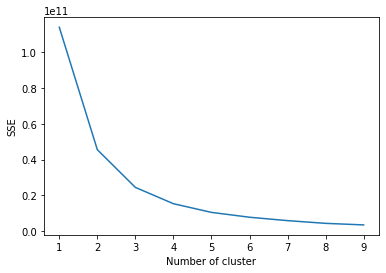

In [5]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    X["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

1. МЕТОД ЛОКТЯ показывает, что после 4-х кластеров дальнейшая сегментация не даёт существенного уменьшения SSE (суммы квадратов ошибок до центра кластера).


2. Для DBSCAN создаём список с вариантами параметра eps и перебираем этот параметр в цикле.
    Смотрим, в каком случае коэффициент силуэта максимальный с приемлемым количеством выбросов.

    Используем X2 = MinMaxScaler().fit_transform(X)

    При eps=0.7 алгоритм DBSCAN выдаёт 2 примерно одинаковых кластера (коэф.силуэта = 0.5892, выбросов 100 наблюдений из 15577).

    В качестве метрики выбираем Коэф.силуэта, т.к. мы не располагаем размеченными данными

### Итак, предварительно рассматриваем версию разбиения на 2-4 кластера. 

In [6]:
param=[]
for x in range(1,10):
    param.append(x/10)
    param.append(round(x/10+0.05,2))
print(param)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [7]:
param[12]

0.7

In [8]:
for i in param[11:13]:
    
    dbscan = DBSCAN(eps=i, min_samples=100)
    dbscan.fit(X2)
    y_pred = dbscan.labels_.astype(np.int)
    s=silhouette_score(X=X2, labels=y_pred, metric='euclidean')
    print('eps ', i, s)
    
    counts = np.unique(y_pred, return_counts=True)
    for count in counts: 
        print(count, end='\n')

eps  0.65 0.5889171856978148
[-1  0  1]
[ 134 7935 7508]
eps  0.7 0.5891135536681107
[-1  0  1]
[ 100 7956 7521]


### Строим график для разбиения на 2 кластера

In [9]:
dbscan = DBSCAN(eps=0.7, min_samples=100)
dbscan.fit(X2)
y_pred = dbscan.labels_.astype(np.int)
s=silhouette_score(X=X2, labels=y_pred, metric='euclidean')
print(s)
    
counts = np.unique(y_pred, return_counts=True)
for count in counts: 
    print(count, end=' ')

0.5891135536681107
[-1  0  1] [ 100 7956 7521] 

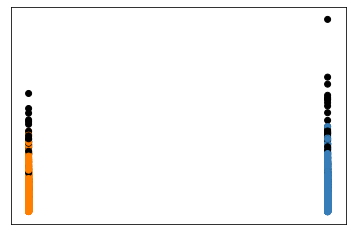

In [10]:
#plt.subplot(f'23{i}')
plt.xticks([]); plt.yticks([])
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00', 
                                     '#b8377e', '#7eb837', '#373eb8', '#37b8b2', '#b8b237', '#b87137' ]),
                                  int(max(y_pred) + 1))))
# чёрным цветом отметим выбросы
colors = np.append(colors, ["#000000"])
plt.scatter(X2[:, 0], X2[:, 1], color=colors[y_pred])

## 2. Методами снижения размерности размещаем стандартизированные наблюдения на двумерной плоскости и визуализируем кластеры

In [11]:
pca = PCA(n_components = 2)
dec = pca.fit_transform(X1)
dec.shape

(15577, 2)

In [12]:
X_embedded = TSNE(n_components=2).fit_transform(X1)
X_embedded.shape

(15577, 2)

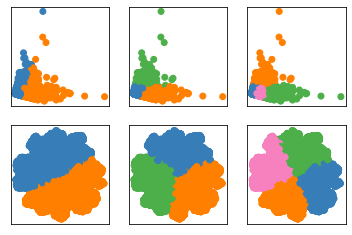

In [13]:
# создаём массив пар – датасета и соответствующих для него параметров алгоритма
datasets_params_list = [
    (dec, {'n_clusters': 2}),
    (dec, {'n_clusters': 3}),
    (dec, {'n_clusters': 4}),
    (X_embedded, {'n_clusters': 2}),
    (X_embedded, {'n_clusters': 3}),
    (X_embedded, {'n_clusters': 4})]

for i, (X, k_means_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    k_means = KMeans(n_clusters=k_means_params['n_clusters'])
    
    k_means.fit(X)
    y_pred = k_means.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])

1. Метод главных компонент PCA в сочетании с K-Means выдает разные по объему кластеры
2. Метод TSNE в сочетании с алгоритмом K-Means разбивает наблюдения примерно на равные по объему кластеры

In [14]:
#break

## 3. Для получения центров кластеризации используем KMeans

Определим количество кластеров перебором значений от 2 до 8. Вычисляем коэф.силуэта.

### 3.1. Для нестандартизированных данных X:
* При 2-х кластерах коэф.силуэта максимальный (0.715)
* При 3-х 0.648
* При 4-х 0.610

Определяем центры получившихся 2-х кластеров, а также центры получившихся 3-х кластеров.

In [15]:
#Для обучения модели K-means необходимо вызвать метод fit, передав входным параметром признаки объектов датасета:
#k_means.fit(X)

#Обучив, мы можем получить центроиды кластеров:
#k_means.cluster_centers_

#И узнать, в какой кластер попал каждый из объектов:
#k_means.labels_

In [16]:
df10=pd.read_excel('Data_Sept2019.xlsx')
X=df10

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X)

scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X)

In [17]:
for i in range(2,9):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    kmeans_pred = kmeans.labels_
    s=silhouette_score(X=X, labels=kmeans_pred, metric='euclidean')
    print('число кластеров ', i, s)

число кластеров  2 0.7149871007837191
число кластеров  3 0.647593852232516
число кластеров  4 0.6096901470552134
число кластеров  5 0.5826602502884427
число кластеров  6 0.5694280582533625
число кластеров  7 0.5635673919460457
число кластеров  8 0.5549235208209898


In [18]:
for i in range(2,5):

    df10=pd.read_excel('Data_Sept2019.xlsx')
    X=df10

    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    a=kmeans.cluster_centers_

    #в какой кластер попал каждый из объектов:
    b=kmeans.labels_

    #Для подсчёта элементов в списке можно воспользоваться функцией numpy.unique с параметром return_counts=True:

    counts = np.unique(b, return_counts=True)
    for count in counts:
        print(count, end=' ')
    
    feature_names=df10.columns.tolist()
    for element in feature_names:
        if element=='Кластер K-means':
            df10=df10.drop(element, axis='columns')

    feature_names=df10.columns
    featureImportance=pd.DataFrame(np.round(a, 2)) 
    featureImportance.columns=feature_names

    df10['Кластер K-means']=df10.apply(lambda x: 0) 

    for number, i in enumerate(b):
        df10.loc[[number],'Кластер K-means']=i

    for number, i in enumerate(count):
        featureImportance.loc[[number],'К-во']=i
    
    list=[]
    list.append(featureImportance.columns[-1])
    for i in feature_names:
        list.append(i)
    
    featureImportance=featureImportance[list].T
    print(featureImportance)
    print('\n')

[0 1] [13476  2101]                             0        1
К-во                 13476.00  2101.00
Пол                      0.50     0.58
ARPU                  1895.43  8026.80
Посещений                1.25     2.57
Коктейли для друзей      0.41     2.37
Акции                    0.40     1.99
Лонги                    1.01     3.71
Пиво для друзей          0.46     1.77
Пиво до 1л               1.83     5.09
Сеты                     1.19     6.29
Наборы на компанию       0.46     1.58
Горячие блюда            0.41     1.47
Горячие напитки          0.06     0.20
Кальяны                  0.19     0.76
Снэки                    0.46     1.31
Соусы, хлеб              0.18     0.61
Холодные напитки         0.28     1.39
Крепкий алкоголь         0.45     3.01
Роллы                    0.23     0.79
Пицца                    0.13     0.44
Супы                     0.03     0.09
Стритфуд                 0.17     0.62
Десерты                  0.05     0.16
Салаты                   0.10     0.32
Вино 

### Итак, методом K-Means для нестандартизированных данных X получаем 2, 3, 4 кластера. Кластеры отличаются по кол-ву посещений и ARPU

#### При разбиении на 2 кластера средние цифры выглядят так:

* 1-й кластер (13476 клиентов): Посещений 1,25 раз в месяц и ARPU 1895 руб. Пол: поровну мужчин и девушек.

* 2-й кластер (2101 клиент): Посещений 2,57 раз в месяц и ARPU 8027 руб. Пол: чаще мужчины, чем девушки. 
Во 2-м кластере посещений на 1 человека в 2 раза больше, при этом непропорционально больше заказывается "Коктейлей для друзей"
(куда входят 3 порции), Лонгов (=коктейлей), Пива для друзей (3 порции в наборе), Крепкий алкоголь и холодные напитки 
(к нему же), Сетов. 
Это более компанейский вариант посещения.


#### При разбиении на 3 кластера средние цифры выглядят так:

Основная масса клиентов попала в кластер 3. Сосредоточим своё внимание на более высокодоходных клиентах из кластеров 1 и 2.
Средние цифры выглядят так:

* 1-й кластер (3610 клиентов): Посещений 1,88 раз в месяц и ARPU 5025 руб. Пол: почти поровну мужчин и девушек.

* 2-й кластер (566 клиентов) самый высокодоходный: Посещений 3,65 раз в месяц и ARPU 12442 руб. Пол: чаще мужчины, чем девушки. 
Во 2-м кластере посещений на 1 человека в 2 раза больше, чем в 1-м, при этом непропорционально больше заказывается Сетов (алкогольных), Крепкого алкоголя и Холодных напитков к ним. А также напитков TO GO и Бизнес-Ланчей. 
Это наиболее компанейский вариант посещения, который возможен даже в дневное время (на что указывают Бизнес-Ланчи).

* 3-й кластер (11401 клиент): Посещений 1,18 раз в месяц и ARPU 1510 руб. Пол: поровну мужчин и девушек.

##### В целом, данное разбиение на 3 кластера видится обоснованным. Он отражает 3 разных сценария посещения бара.


#### Разбиение на 4 кластера приведено справочно.



###  3.2. Теперь сделаем кластеризацию стандартизированных данных X1

Число кластеров при переборе ограничим от 2-х до 4.

In [19]:
df10=pd.read_excel('Data_Sept2019.xlsx')
X=df10

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X)

scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X)

In [20]:
for i in range(2,5):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X1)
    kmeans_pred = kmeans.labels_
    s=silhouette_score(X=X1, labels=kmeans_pred, metric='euclidean')
    print('число кластеров ', i, s)

число кластеров  2 0.4071073610883552
число кластеров  3 0.3987183781909582
число кластеров  4 0.23856164975916871


In [21]:
kmeansS = KMeans(n_clusters=2, random_state=42)
kmeansS.fit(X1)
aS=kmeansS.cluster_centers_

#в какой кластер попал каждый из объектов:
bS=kmeansS.labels_

#Для подсчёта элементов в списке можно воспользоваться функцией numpy.unique с параметром return_counts=True:

counts = np.unique(bS, return_counts=True)
for count in counts:
    print(count, end=' ')

[0 1] [ 2061 13516] 

* Метод K-Means для стандартизированных данных X1 выдал 2 кластера с максимальным коэф.силуэта 0.4071. Нас это не устраивает.

### 3.3. Применим K-Means для нормализованных данных X2:

несмотря на неубедительные коэф.силуэта, кластеризация происходит с жёсткой разбивкой по полу (м/ж), что представляет интерес.


In [22]:
for i in range(2,5):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X2)
    kmeans_pred = kmeans.labels_
    s=silhouette_score(X=X2, labels=kmeans_pred, metric='euclidean')
    print('число кластеров ', i, s)

число кластеров  2 0.5874937870542654
число кластеров  3 0.3862716109232294
число кластеров  4 0.19262425213800471


In [23]:
for i in range(2,5):
    
    df10=pd.read_excel('Data_Sept2019.xlsx')
    X=df10
    scaler2 = MinMaxScaler()
    X2 = scaler2.fit_transform(X)
    
    kmeansM = KMeans(n_clusters=i, random_state=42)
    kmeansM.fit(X2)
    aM=kmeansM.cluster_centers_
    aM2=scaler2.inverse_transform(aM)
    #ВАЖНО: ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ

    #в какой кластер попал каждый из объектов:
    bM=kmeansM.labels_

    #Для подсчёта элементов в списке можно воспользоваться функцией numpy.unique с параметром return_counts=True:

    counts = np.unique(bM, return_counts=True)
    for count in counts:
        print(count, end=' ')
        
    feature_names=df10.columns.tolist()
    for element in feature_names:
        if element=='Кластер K-means':
            df10=df10.drop(element, axis='columns')

    feature_names=df10.columns
    featureImportance=pd.DataFrame(np.round(aM2, 2)) 
    featureImportance.columns=feature_names

    df10['Кластер K-means']=df10.apply(lambda x: 0) 

    for number, i in enumerate(bM):
        df10.loc[[number],'Кластер K-means']=i

    for number, i in enumerate(count):
        featureImportance.loc[[number],'К-во']=i
    
    list=[]
    list.append(featureImportance.columns[-1])
    for i in feature_names:
        list.append(i)
    
    featureImportance=featureImportance[list].T
    print(featureImportance)
    print('\n')

[0 1] [8016 7561]                            0        1
К-во                 8016.00  7561.00
Пол                     1.00     0.00
ARPU                 2868.34  2567.72
Посещений               1.48     1.39
Коктейли для друзей     0.61     0.74
Акции                   0.66     0.57
Лонги                   1.11     1.65
Пиво для друзей         0.81     0.45
Пиво до 1л              2.56     1.96
Сеты                    2.05     1.69
Наборы на компанию      0.66     0.57
Горячие блюда           0.55     0.56
Горячие напитки         0.09     0.08
Кальяны                 0.26     0.28
Снэки                   0.58     0.58
Соусы, хлеб             0.23     0.24
Холодные напитки        0.47     0.39
Крепкий алкоголь        0.99     0.58
Роллы                   0.23     0.39
Пицца                   0.16     0.18
Супы                    0.04     0.04
Стритфуд                0.25     0.21
Десерты                 0.04     0.08
Салаты                  0.10     0.15
Вино 125 мл             0.08    

## Итак, методом K-Means для нормализованных данных X2 рассмотрим 4 кластера, отличающихся по полу (м/ж) и дню недели для посещения (сб).

Средние цифры выглядят так:

* Для мужчин (кластеры номер 2 и 3):

Количество клиентов соответственно 5836 и 2180. 
За 1 месяц они в среднем тратят соответственно 2497 руб. за 1,33 посещений или же 3863 руб. за 1,85 посещений.
Клиенты с более высокими расходами непропорционально больше заказывают "Коктейли для друзей" (3 порции в одном наборе), Кальянов; меньше подпадают под Акции и меньше заказывают Бизнес-Ланчей. Это сценарий посещения в прайм-тайм в календарную субботу (это может быть также ночное время пт/сб и сб/вс).

* Рассмотрим кластеры, которые сформированы девушками (номер 1 и 4):

Количество клиентов соответственно 5576 и 1985. 
За 1 месяц они в среднем тратят соответственно 2262 руб. за 1,28 посещений или же 3428 руб. за 1,67 посещений.
Клиенты с более высокими расходами непропорционально больше заказывают "Коктейли для друзей" (3 порции в одном наборе), Сеты (на компанию), Крепкий алкоголь, Десерты, Напитки TO GO (с собой); меньше подпадают под Акции. Это сценарий посещения в прайм-тайм в календарную субботу (это может быть также ночное время пт/сб и сб/вс).

* Если дополнительно рассмотреть разбиение на только 2 кластера (также жёсткое по полу м/ж), то можно видеть, что  у девушек выше спрос на вино, лонги (коктейли), роллы, салаты и десерты по сравнению с мужчинами, и меньше интерес к крепкому алкоголю и "пиву для друзей". 

## В целом, данное разбиение на 4 кластера видится обоснованным



## 4. Теперь посмотрим результаты Агломеративной кластеризации.

Максимальные коэф.силуэта без матрицы смежности / с матрицей смежности соответствуют разбиению на 2 кластера.

## По Агломеративной кластеризации код закомментирован, т.к. долго отрабатывается

In [24]:
df10=pd.read_excel('Data_Sept2019.xlsx')
X=df10

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X)

scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X)

In [25]:
list=[X,X1,X2]

In [26]:
for number, j in enumerate(list):
    
    if number==0:
        print('Для массива X')     
    elif number==1:
        print('Для массива X1')
    else:
        print('Для массива X2')
    
    for i in range(2,5):
        ac1 = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
        with warnings.catch_warnings():
            warnings.filterwarnings(
            "ignore",
                message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            ac1.fit(j)
        y_pred1 = ac1.labels_.astype(np.int)
        s=silhouette_score(X=j, labels=y_pred1, metric='euclidean')
            
        print('число кластеров ', i, s)
    
    # строим матрицу смежности
    # делаем матрицу смежности симметричной

    connectivity = kneighbors_graph(X, n_neighbors=6, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    for i in range(2,5):
        ac1 = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', connectivity=connectivity 
                            )
        with warnings.catch_warnings():
            warnings.filterwarnings(
            "ignore",
                message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            ac1.fit(j)
        y_pred1 = ac1.labels_.astype(np.int)
        s=silhouette_score(X=j, labels=y_pred1, metric='euclidean')
        print('число кластеров с матрицей смежности ', i, s)
    print('\n')

Для массива X
число кластеров  2 0.734307884682819
число кластеров  3 0.6005100182126275
число кластеров  4 0.6101046799983515
число кластеров с матрицей смежности  2 0.734307884682819
число кластеров с матрицей смежности  3 0.5138113171394809
число кластеров с матрицей смежности  4 0.5180033383507094


Для массива X1
число кластеров  2 0.2398044034961178
число кластеров  3 0.23847395393998883
число кластеров  4 0.23253928465410917
число кластеров с матрицей смежности  2 0.21399748982003344
число кластеров с матрицей смежности  3 0.17114248605192586
число кластеров с матрицей смежности  4 0.17147325880243158


Для массива X2
число кластеров  2 0.5874251001605947
число кластеров  3 0.3859901515001356
число кластеров  4 0.19505963438721918
число кластеров с матрицей смежности  2 0.012857824587063785
число кластеров с матрицей смежности  3 -0.08266696011439133
число кластеров с матрицей смежности  4 -0.10341466843314706




## 5. Иерархическая кластеризация 

## По Иерархической кластеризации код закомментирован, т.к. долго отрабатывается

* Для нестандартизированных данных X получили 2-4 кластера.

In [27]:
df10=pd.read_excel('Data_Sept2019.xlsx')
X=df10

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X)

scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X)

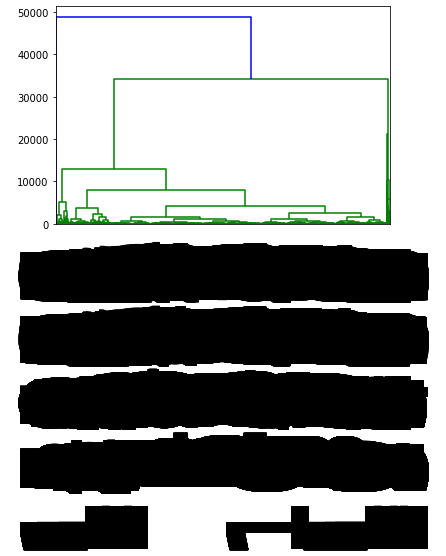

In [28]:
mergings=linkage(X.sort_values(by=['ARPU', 'Посещений', 'Пол']).values, method='complete')
dendrogram(mergings, leaf_font_size=100)
plt.show()

### Подтверждается разбиение на 2-4 основных кластера:

* разбивка на 2 кластера по ARPU (метод K-Means для нестандартизированных данных)


* разбивка на 3 кластера (3 разных сценарии посещения бара клиентами: редкое посещение (1,18 раз) с ARPU 1510 руб; более частое посещение (1,88 раз) с ARPU 5025 руб; частое посещение большой компанией - 3,65 раз с ARPU 12442 руб в месяц). Использовался метод K-Means для нестандартизированных данных.


* Вместо 2-х кластеров считаем целесообразным использовать разбивку на 4 кластера, которыая учитывает пол клиентов (м/ж) и день недели посещения (week-end или нет). Кластеры получены методом K-Means для нормализованных данных.